# Pre-Processing images

In [206]:
import cv2
import numpy as np
from glob import glob
import os
from PIL import Image
from IPython.display import display


Original image


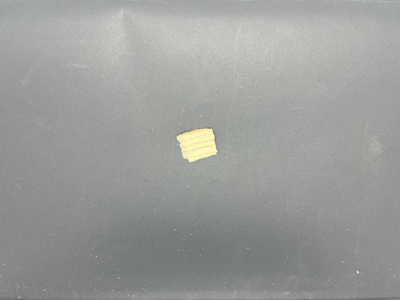

In [225]:
img = Image.open('Data_WoodChips/Fi_6088.JPG')
img_resized = img.resize((400, 300))
print('Original image')
display(img_resized)


## Crop Imagas and make sure to not loss any usefull information

In [216]:
def crop_images(file_path, save_path):
    img = cv2.imread(file_path)
    img = img[1450:2650,900:2100,:]
    cv2.imwrite(save_path, img)

image_path = glob('Data_WoodChips/*.JPG')  # Make sure to provide the path to your image
for file_path in image_path:
    
    save_path = f'./image_set_1/' + os.path.basename(file_path)  # Output path
    crop_images(file_path, save_path)

    

croped image


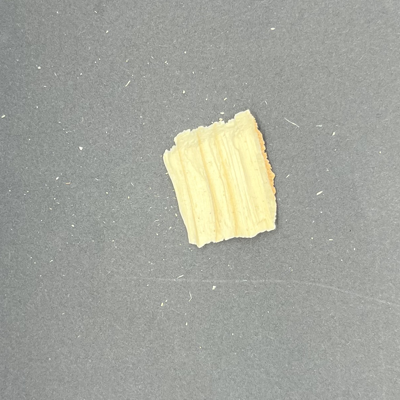

In [224]:
img = Image.open('./image_set_1/Fi_6088.JPG')
img_resized = img.resize((400, 400))
print('croped image')
display(img_resized)

## Remove background with OpenCV technique 

In [218]:
def remove_black_background(file_path, save_path):
    # Read the image
    img = cv2.imread(file_path,)
    #img = img[1450:2650,900:2100,:]
    # Check if the image has an alpha channel
    has_alpha = img.shape[2] == 4
    
    # Convert image to RGBA if it does not already have an alpha channel
    if not has_alpha:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    
    # Create a mask where black regions are 0 and white regions are 255
    lower = np.array([0, 0, 0, 0], dtype = "uint8")  # Lower bound for black
    upper = np.array([220, 190, 190, 255], dtype = "uint8")  # Upper bound for black, adjust these values as needed
    mask = cv2.inRange(img, lower, upper)
    
    # Make the black background transparent
    img[mask == 255] = [0, 0, 0, 0]
    
    # Save the image with a transparent background
    cv2.imwrite(save_path, img)


image_path = glob('image_set_1/*.JPG')  # Make sure to provide the path to your image
for file_path in image_path:
    save_path = f'image_set_2/' + os.path.basename(file_path)  # Output path
    remove_black_background(file_path, save_path)

removed background image


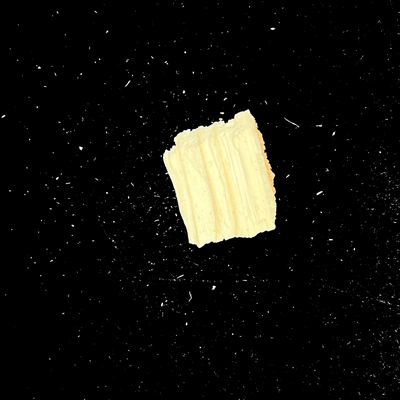

In [222]:
img = Image.open('./image_set_2/Fi_6088.JPG')
img_resized = img.resize((400, 400))
print('removed background image')
display(img_resized)

## Remove noise from images with OpenCV technique

In [220]:
def de_noise_image(file_path,save_path):
    # Load the image
    image = cv2.imread(file_path)    
    
    # Create a copy of the image to apply denoising
    image_denoised = image.copy()
    
    # Apply Non-Local Means Denoising to the copy
    image_denoised = cv2.medianBlur(image, 7)
    image_denoised = cv2.cvtColor(image_denoised, cv2.COLOR_BGR2GRAY)
    
    # Create a mask where the area to preserve is set to 1 and everything else to 0
    mask = np.zeros(image.shape[:2], dtype="uint8")  # Assuming a 2D mask for a grayscale image
    
    ret, mask = cv2.threshold(image_denoised, 100, 255, cv2.THRESH_BINARY)
    mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    masked_image = cv2.bitwise_and(image, mask_3channel)
    
    # Save or display the result
    cv2.imwrite(save_path, masked_image)
    del image
    del image_denoised
    del masked_image
    del mask
    
image_path = glob('image_set_2/*.JPG')  # Make sure to provide the path to your image
for file_path in image_path:    
    save_path = f'image_set_3/' + os.path.basename(file_path)  # Output path
    de_noise_image(file_path, save_path)


removed background image


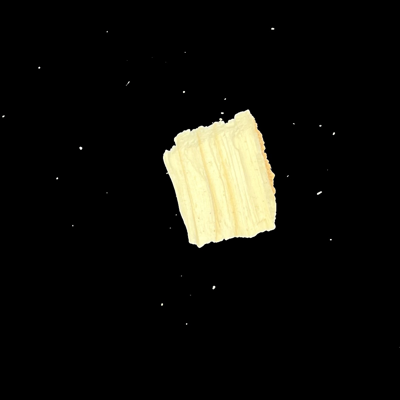

In [223]:
img = Image.open('./image_set_3/Fi_6088.JPG')
img_resized = img.resize((400, 400))
print('removed background image')
display(img_resized)

# Train Deep Leaning Model

In [ ]:
!pip install timm albumentations tensorboard


## Load labriries

In [47]:
import os
import glob
import pandas as pd
from time import time
import glob
from tqdm import tqdm
import timm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torchvision.transforms import ToTensor
import torch
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.nn.modules.distance import PairwiseDistance
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import io
from tensorboard import notebook

## Use second GPU for training model on my machine
##### Change to "0" if you have only one GPU installed on your machine

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


## Training Hyper-Parameters

In [3]:

hyper_parameters = {
    'epoch': 30,
    'embedding_dimension': 128,
    'clas_num':2,
    'num_triplets':2000,
    'batch_size_training': 3,
    'model_architecture': 'efficientnet_b1',
    'margin':0.5,
    'optimizer_lr':1e-3,
    'alpha':10,
    'batch_size':2,
    'image_size':(224,224),
    'optimizer_name': 'Adam',    
    'freeze_CNN': True,
    'device' : 'cuda',

}



## Generate CSV files from images in TrainSet and EvalSet

In [4]:
def generate_csv_file(dataroot, csv_name):

    print("\nLoading image paths ...")
    files = glob.glob(dataroot + "/*/*")
    print(files)
    start_time = time()
    list_rows = []

    print("Number of files: {}".format(len(files)))
    print("\nGenerating csv file ...")

    progress_bar = enumerate(tqdm(files))

    for file_index, file in progress_bar:

        face_id = os.path.basename(file).split('.')[0]
        face_label = os.path.basename(os.path.dirname(file))

        # Better alternative than dataframe.append()
        row = {'id': face_id, 'name': face_label}
        list_rows.append(row)

    dataframe = pd.DataFrame(list_rows)
    dataframe = dataframe.sort_values(by=['name', 'id']).reset_index(drop=True)

    # Encode names as categorical classes
    dataframe['class'] = pd.factorize(dataframe['name'])[0]
    dataframe.to_csv(path_or_buf=csv_name, index=False)

    elapsed_time = time()-start_time
    print("\nDone! Elapsed time: {:.2f} minutes.".format(elapsed_time/60))


generate_csv_file(dataroot='./dataset/train', csv_name='trainset.csv')
generate_csv_file(dataroot='./dataset/eval', csv_name='evalset.csv')
generate_csv_file(dataroot='./dataset/test', csv_name='test.csv')


Loading image paths ...
['./dataset/train/0/Fi_IMG_5859.JPG', './dataset/train/0/Fi_IMG_5881.JPG', './dataset/train/0/Fi_IMG_5853.JPG', './dataset/train/0/Fi_6067.JPG', './dataset/train/0/Fi_IMG_5886.JPG', './dataset/train/0/Fi_IMG_5874.JPG', './dataset/train/0/Fi_IMG_5879.JPG', './dataset/train/0/FI_IMG_5957.JPG', './dataset/train/0/Fi_6095.JPG', './dataset/train/0/FI_IMG_5952.JPG', './dataset/train/0/Fi_IMG_5872.JPG', './dataset/train/0/Fi_6064.JPG', './dataset/train/0/Fi_6065.JPG', './dataset/train/0/Fi_IMG_5854.JPG', './dataset/train/0/Fi_6078.JPG', './dataset/train/0/FI_IMG_5949.JPG', './dataset/train/0/Fi_6100.JPG', './dataset/train/0/Fi_6071.JPG', './dataset/train/0/Fi_6051.JPG', './dataset/train/0/Fi_IMG_5880.JPG', './dataset/train/0/Fi_6061.JPG', './dataset/train/0/FI_IMG_5950.JPG', './dataset/train/0/Fi_6093.JPG', './dataset/train/0/Fi_6063.JPG', './dataset/train/0/FI_IMG_5955.JPG', './dataset/train/0/Fi_6062.JPG', './dataset/train/0/Fi_6074.JPG', './dataset/train/0/Fi_IMG_5

100%|██████████| 148/148 [00:00<00:00, 104981.73it/s]



Done! Elapsed time: 0.00 minutes.

Loading image paths ...
['./dataset/eval/0/Fi_6109.JPG', './dataset/eval/0/FI_IMG_5947.JPG', './dataset/eval/0/Fi_IMG_5875.JPG', './dataset/eval/0/Fi_6094.JPG', './dataset/eval/0/Fi_6049.JPG', './dataset/eval/1/KI_IMG_5930.JPG', './dataset/eval/1/KI_IMG_5919.JPG', './dataset/eval/1/KI_IMG_5926.JPG', './dataset/eval/1/Ki_IMG_5861.JPG', './dataset/eval/1/KI_IMG_5927.JPG']
Number of files: 10

Generating csv file ...


100%|██████████| 10/10 [00:00<00:00, 73973.62it/s]



Done! Elapsed time: 0.00 minutes.

Loading image paths ...
['./dataset/test/0/Fi_6085.JPG', './dataset/test/0/Fi_IMG_5873.JPG', './dataset/test/1/KI_IMG_5929.JPG', './dataset/test/1/KI_IMG_5925.JPG']
Number of files: 4

Generating csv file ...


100%|██████████| 4/4 [00:00<00:00, 41323.19it/s]


Done! Elapsed time: 0.00 minutes.


## Create Triplet Dataset class that return 3 images. Two images from a same class and one from another class

In [5]:

class TripletDataset(Dataset):

    def __init__(self,csv_file,root_path,num_triplets=200,transform=None,padding=False,imag_size=(224,224)):


        # Modified here to set the data types of the dataframe columns to be suitable for other datasets other than the
        #   VggFace2 dataset (Casia-WebFace in this case because of the identities starting with numbers automatically
        #   forcing the 'name' column as being of type 'int' instead of type 'object')




        csv_name = csv_file
        self.df = pd.read_csv(csv_name, dtype={'id': object, 'name': object, 'class': int})
        self.root_dir = root_path
        self.num_triplets = num_triplets
        self.transform = transform
        self.padding = padding
        self.save=False        

        self.training_triplets = self.generate_triplets(self.df, self.num_triplets)


    @staticmethod
    def generate_triplets(df, num_triplets):

        def make_dictionary_for_class(df):
            """
              - image_classes = {'class0': [class0_id0, ...], 'class1': [class1_id0, ...], ...}
            """
            image_classes = dict()
            for idx, label in enumerate(df['class']):
                if label not in image_classes:
                    image_classes[label] = []
                image_classes[label].append(df.iloc[idx, 0])

            return image_classes

        triplets = []
        classes = df['class'].unique()
        image_classes = make_dictionary_for_class(df)

        # Modified here to add a print statement
        print("\nGenerating {} triplets...".format(num_triplets))

        #progress_bar = tqdm(range(num_triplets))
        for _ in range(num_triplets):

            """
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            """

            pos_class = np.random.choice(classes)
            neg_class = np.random.choice(classes)

            while len(image_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)

            while pos_class == neg_class:
                neg_class = np.random.choice(classes)

            pos_name = df.loc[df['class'] == pos_class, 'name'].values[0]
            neg_name = df.loc[df['class'] == neg_class, 'name'].values[0]

            if len(image_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size=2, replace=False)

            else:
                ianc = np.random.randint(0, len(image_classes[pos_class]))
                ipos = np.random.randint(0, len(image_classes[pos_class]))

                while ianc == ipos:
                    ipos = np.random.randint(0, len(image_classes[pos_class]))

            ineg = np.random.randint(0, len(image_classes[neg_class]))

            triplets.append(
                [
                    image_classes[pos_class][ianc],
                    image_classes[pos_class][ipos],
                    image_classes[neg_class][ineg],
                    pos_class,
                    neg_class,
                    pos_name,
                    neg_name
                ]
            )
       

        df = pd.DataFrame(triplets)
        df.to_csv('training_triplets_{}.csv'.format(num_triplets))
        return triplets

    def __getitem__(self, idx):

        anc_id, pos_id, neg_id, pos_class, neg_class, pos_name, neg_name = self.training_triplets[idx]
        anc_img = self.add_extension(os.path.join(self.root_dir, str(pos_name), str(anc_id)))      
        pos_img = self.add_extension(os.path.join(self.root_dir, str(pos_name), str(pos_id)))    
        neg_img = self.add_extension(os.path.join(self.root_dir, str(neg_name), str(neg_id)))
      

        # Modified to open as PIL image in the first place
        anc_img = Image.open(anc_img)
        pos_img = Image.open(pos_img)
        neg_img = Image.open(neg_img)

        if self.padding:

            anc_img = anc_img.resize((180,180),2)
            anc_new = Image.new('RGB', (224, 224),color = 'black')
            anc_new.paste(anc_img,(22,22))

            pos_img = pos_img.resize((180,180),2)
            pos_new = Image.new('RGB', (224, 224),color = 'black')
            pos_new.paste(pos_img,(22,22))

            neg_img = neg_img.resize((180,180),2)
            neg_new = Image.new('RGB', (224, 224),color = 'black')
            neg_new.paste(neg_img,(22,22))

            anc_img = anc_new
            pos_img = pos_new
            neg_img = neg_new

            if self.save==False:
                anc_img.save("test_2.png")
                self.save=True



        pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))
        neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))

        sample = {
            'anc_img': anc_img,
            'pos_img': pos_img,
            'neg_img': neg_img,
            'pos_class': pos_class,
            'neg_class': neg_class
        }

        if self.transform:
            sample['anc_img'] = np.asanyarray(sample['anc_img'])
            sample['pos_img'] = np.asanyarray(sample['pos_img'])
            sample['neg_img'] = np.asanyarray(sample['neg_img'])

            sample['anc_img'] = self.transform(image=sample['anc_img'])["image"]
            sample['pos_img'] = self.transform(image=sample['pos_img'])["image"]
            sample['neg_img'] = self.transform(image=sample['neg_img'])["image"]

        return sample


    def __len__(self):
        return len(self.training_triplets)

    # Added this method to allow .jpg and .png image support
    def add_extension(self, path):
        if os.path.exists(path + '.JPG'):
            return path + '.JPG'
        elif os.path.exists(path + '.png'):
            return path + '.png'
        else:
            raise RuntimeError('No file "%s" with extension png or jpg.' % path)


## Use Data Augmentation Technique and Normalize pixle values to efficentNet pre-trained weight machets.

In [6]:


image_size = (224,224)
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),       
        A.RandomBrightnessContrast(brightness_limit=(-0.,0.1),contrast_limit=0.0,p=0.1),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=30, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.SmallestMaxSize(max_size=image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


triplet_dataset = TripletDataset(
           csv_file='./trainset.csv',
           root_path='./dataset/train' ,
           transform=train_transforms,
           num_triplets=hyper_parameters['num_triplets'],
        )

df = pd.read_csv('./trainset.csv')
print("Number of duplicated row:",df.duplicated(keep=False).sum())

train_triplet_dataloader = torch.utils.data.DataLoader(
        dataset=triplet_dataset,
        batch_size=3,
        shuffle=True,
    )



Generating 2000 triplets...
Number of duplicated row: 0


## Normalize and visualaize images from triplet dataset

In [7]:
def unnrmalize(tensor):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)  # Multiply by std and add mean
        
        tensor = tensor.numpy()
        tensor = np.transpose(tensor, (1, 2, 0))
    
        return tensor
       

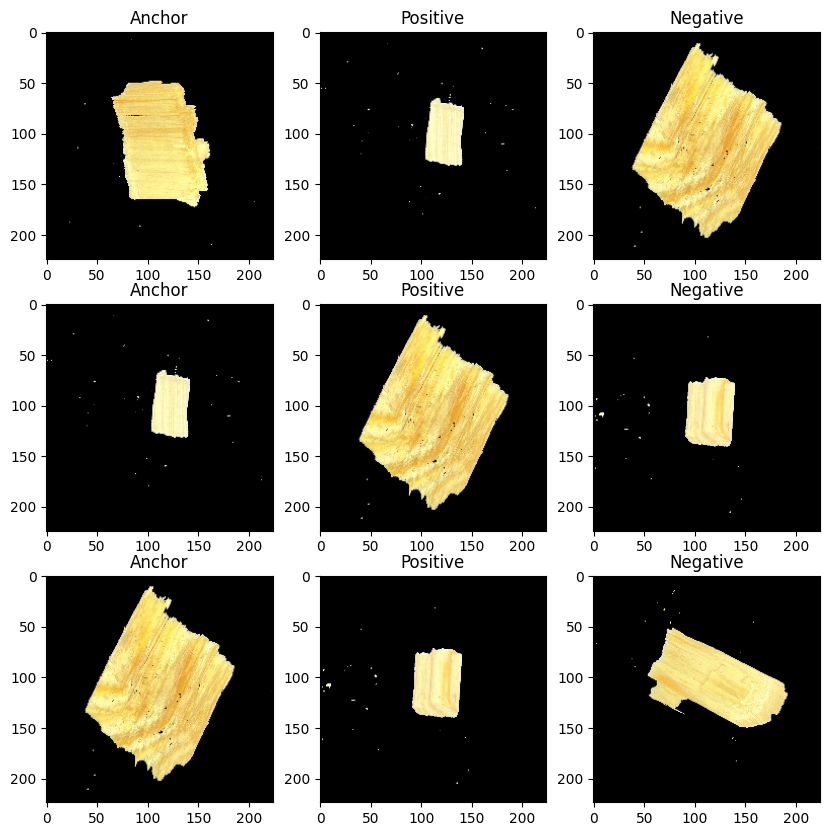

In [8]:
dataiter = iter(train_triplet_dataloader)
sample = next(dataiter)
imag_np = []
fig, axs = plt.subplots(3, 3, figsize=(10, 10)) 

titles = ['Anchor', 'Positive', 'Negative']
for batch in range(3):
    for idx,key in enumerate(['anc_img','pos_img','neg_img']):
        imag_np.append(unnrmalize(sample[key][batch]))
        axs[batch,idx].imshow(imag_np[idx+batch])                
        axs[batch,idx].set_title(titles[idx])

    #plt.axis('off')  
plt.show()

## Create a dataset class to evaluate TrainSet and EvalSet accuracy.

In [9]:

class Eval_Dataset(Dataset):

    # def __init__(self, root_dir, csv_name, train_flag = True , transform=None):
    def __init__(self, root_path, csv_file,transform=None,imag_size=(224,224)):

        self.df = pd.read_csv(csv_file, dtype={'id': object, 'name': object, 'class': int})
        self.transform = transform
        self.root= root_path
        print(self.root)
        print(len(self.df))


    def __getitem__(self, idx):

        file_name, folder_name, class_num = self.df.iloc[idx]
        # print("file_name:",file_name)
        # print("Class_nume:",class_num)
        img_path = self.add_extension(os.path.join(self.root, str(folder_name), str(file_name)))
        # print("image_parh:",img_path)

        # Modified to open as PIL image in the first place
        img = Image.open(img_path)
        # img = np.asanyarray(img)

        sample = {
            'image': img,
            'class': class_num,
            'file_name': file_name,
            'folder_name': folder_name,
        }

        if self.transform:
            sample['image'] = np.asanyarray(sample['image'])
            sample['image'] = self.transform(image=sample['image'])["image"]

        return sample

    def __len__(self):
        return len(self.df)

    # Added this method to allow .jpg and .png image support
    def add_extension(self, path):
        if os.path.exists(path + '.JPG'):
            return path + '.JPG'
        elif os.path.exists(path + '.png'):
            return path + '.png'
        else:
            raise RuntimeError('No file "%s" with extension png or jpg.' % path)


## Create trasforms and dataloader for accuracy check

In [10]:

eval_train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


train_acc_dataset = Eval_Dataset(
           csv_file='./trainset.csv',
           root_path='./dataset/train' ,
           transform=eval_train_transforms, )

train_acc_dataloader = torch.utils.data.DataLoader(
        dataset=train_acc_dataset,
        batch_size=1,
        num_workers=5,
        shuffle=True
    )



eval_acc_dataset = Eval_Dataset(
           csv_file='./evalset.csv',
           root_path='./dataset/eval' ,
           transform=eval_train_transforms )


eval_acc_dataloader = torch.utils.data.DataLoader(
        dataset= eval_acc_dataset,
        batch_size=1,
        num_workers=5,
        shuffle=True
    )

test_dataset = Eval_Dataset(
           csv_file='./test.csv',
           root_path='./dataset/test' ,
           transform=eval_train_transforms )


test_dataloader = torch.utils.data.DataLoader(
        dataset= test_dataset,
        batch_size=1,
        num_workers=5,
        shuffle=False
    )



./dataset/train
148
./dataset/eval
10
./dataset/test
4


## Normalize and visualaize images from eval and test dataset

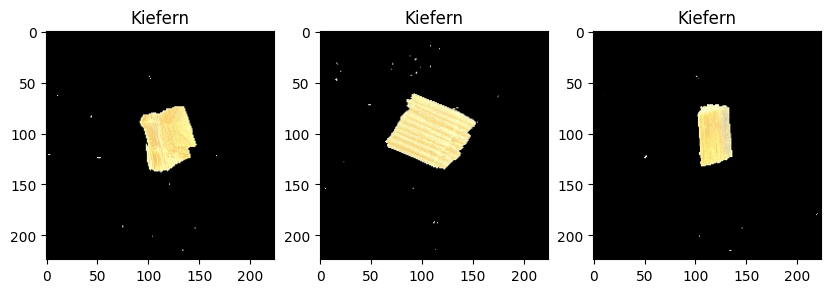

In [11]:
dataiter = iter(eval_acc_dataloader)
imag_np = []
fig, axs = plt.subplots(1, 3, figsize=(10, 10)) 

titles = ['Fichten', 'Kiefern']
for batch in range(3): 
    sample = next(dataiter)
    imag_np.append(unnrmalize(sample['image'][0]))
    axs[batch].imshow(imag_np[batch])                
    
    axs[batch].set_title(titles[sample['class'].item()])
    

    #plt.axis('off')  
plt.show()

## Make model EfficientNet-b0 withembedding and extra layer fully connected layer.

In [12]:

class EfficientnetTriplet(nn.Module):
    """Constructs a efficentnet model for FaceNet training using triplet loss.

    Args:
        embedding_dimension (int): Required dimension of the resulting embedding layer that is outputted by the model.
                                   using triplet loss. Defaults to 128.
        pretrained (bool): If True, returns a model pre-trained on the ImageNet dataset from a PyTorch repository.
                           Defaults to False.
    """

    def __init__(self, model_arch='efficientnet_b1',embedding_dimension=128,class_num=2, pretrained=False,alpha=10):
        super(EfficientnetTriplet, self).__init__()
        self.model = timm.create_model(model_arch,pretrained=pretrained)
        input_features_fc_layer = self.model.classifier.in_features
        # Output embedding
        
        self.model.classifier = nn.Linear(input_features_fc_layer, embedding_dimension)
        self.extra_classifier = nn.Linear(embedding_dimension, class_num)
        self.alpha = alpha
    def l2_norm(self, input):
        """Perform l2 normalization operation on an input vector.
        code copied from liorshk's repository: https://github.com/liorshk/facenet_pytorch/blob/master/model.py
        """
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)

        return output

    def forward(self, images):
        """Forward pass to output the embedding vector (feature vector) after l2-normalization and multiplication
        by scalar (alpha)."""
        embedding = self.model(images)
        embedding = self.l2_norm(embedding)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        #   Equation 9: number of classes in VGGFace2 dataset = 9131
        #   lower bound on alpha = 5, multiply alpha by 2; alpha = 10
        #alpha = 10
        embedding = embedding * self.alpha

        class_out =  self.extra_classifier(embedding)
        return embedding,class_out

model = EfficientnetTriplet(model_arch=hyper_parameters['model_architecture'],embedding_dimension=hyper_parameters['embedding_dimension'],class_num=hyper_parameters['clas_num'], pretrained=True,alpha=hyper_parameters['alpha'])
DEVICE = hyper_parameters['device']
model.to(DEVICE)


EfficientnetTriplet(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_s

## Function to freeze model except embedding and classifier layers

In [13]:
def freeze_model(model,freeze_CNN):
    # if freeze_CNN:
    for param in model.parameters():
        param.requires_grad = not freeze_CNN
   
    for param in model.model.classifier.parameters(): 
        param.requires_grad = True
        
    for param in model.extra_classifier.parameters():
        param.requires_grad = True
            

freeze_model(model,hyper_parameters['freeze_CNN'])

## Make sure the model frozen

In [14]:
for name, param in model.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

model.conv_stem.weight is frozen
model.bn1.weight is frozen
model.bn1.bias is frozen
model.blocks.0.0.conv_dw.weight is frozen
model.blocks.0.0.bn1.weight is frozen
model.blocks.0.0.bn1.bias is frozen
model.blocks.0.0.se.conv_reduce.weight is frozen
model.blocks.0.0.se.conv_reduce.bias is frozen
model.blocks.0.0.se.conv_expand.weight is frozen
model.blocks.0.0.se.conv_expand.bias is frozen
model.blocks.0.0.conv_pw.weight is frozen
model.blocks.0.0.bn2.weight is frozen
model.blocks.0.0.bn2.bias is frozen
model.blocks.0.1.conv_dw.weight is frozen
model.blocks.0.1.bn1.weight is frozen
model.blocks.0.1.bn1.bias is frozen
model.blocks.0.1.se.conv_reduce.weight is frozen
model.blocks.0.1.se.conv_reduce.bias is frozen
model.blocks.0.1.se.conv_expand.weight is frozen
model.blocks.0.1.se.conv_expand.bias is frozen
model.blocks.0.1.conv_pw.weight is frozen
model.blocks.0.1.bn2.weight is frozen
model.blocks.0.1.bn2.bias is frozen
model.blocks.1.0.conv_pw.weight is frozen
model.blocks.1.0.bn1.weig

## Create embedding projrction with pretrained model's weight

In [24]:
def get_model_device(model):
    return next(model.parameters()).device

def extract_embeddings(dataloader, model):
    device = get_model_device(model)
    with torch.no_grad():
        embeddings = []
        labels = []
        image_data = []  # Store images for logging
        for sample in dataloader:
            images = sample['image']
            
            targets = sample['class']
            images = images.to(device)
            emb,classifier = model(images)
            embeddings.append(emb.cpu().numpy())
            labels.append(targets.numpy())
            image_data.append(images.cpu().numpy())  # Collect image data
        embeddings = np.concatenate(embeddings, axis=0)
        image_data = np.concatenate(image_data, axis=0)
        labels = np.concatenate(labels, axis=0)
    return embeddings, classifier,labels, image_data

embeddings, classifier,labels, images = extract_embeddings(train_acc_dataloader, model)

writer = SummaryWriter('./mondi_result/runs/pretrained_model')
writer.add_embedding(torch.tensor(embeddings),
                     #metadata=labels,
                     label_img=torch.tensor(images),
                     global_step=0)
writer.close()


In [25]:
notebook.display(port=6006, height=1000)

## Tripletloss that gets 3 embedding vector as input and returns loss as output

In [26]:
class TripletLoss(Function):

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)

    def forward(self, anchor, positive, negative):
        pos_dist = self.pdist.forward(anchor, positive)
        neg_dist = self.pdist.forward(anchor, negative)

        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min=0.0)
        loss = torch.mean(hinge_dist)

        return loss


## Train and validation functions 

In [27]:


def train_model(model, train_dataloader, model_architecture,optimizer,margin,epoch,alpha_triplet=25.,alpha_contrastive=2.2):
    device = get_model_device(model)
    criterion = torch.nn.CrossEntropyLoss()
    # contrastive = ContrastiveLoss(margin=margin)
    num_valid_training_triplets = 0
    triplet_loss_sum = 0
    contrastive_loss_sum = 0
    cross_loss_sum =0
    l2_distance = PairwiseDistance(2).to(device)


    model.train()

    for batch_idx, (batch_sample) in enumerate(train_dataloader):


        anc_img = batch_sample['anc_img'].to(device)
        pos_img = batch_sample['pos_img'].to(device)
        neg_img = batch_sample['neg_img'].to(device)
        pos_class = batch_sample['pos_class'].to(device)
        neg_class = batch_sample['neg_class'].to(device)
        pos_class = pos_class.view(1,-1).squeeze(0)
        neg_class = neg_class.view(1,-1).squeeze(0)

        # Forward pass - compute embeddings
        (anc_embedding,anc_CC), (pos_embedding,pos_CC), (neg_embedding,neg_CC) = model(anc_img), model(pos_img), model(neg_img)
        #print("begining mini batch train stage memory:",torch.cuda.memory_allocated(0))
        # Forward pass - choose hard negatives only for training
        pos_dist = l2_distance.forward(anc_embedding, pos_embedding)
        neg_dist = l2_distance.forward(anc_embedding, neg_embedding)
        all = (neg_dist - pos_dist < margin).cpu().numpy().flatten()

        hard_triplets = np.where(all == 1)
        if len(hard_triplets[0]) == 0:
                continue



        # print("\nhard_triplets:",hard_triplets)
        anc_hard_embedding = anc_embedding[hard_triplets].to(device)
        pos_hard_embedding = pos_embedding[hard_triplets].to(device)
        neg_hard_embedding = neg_embedding[hard_triplets].to(device)

        triplet_loss = TripletLoss(margin=margin).forward(
                anchor=anc_hard_embedding,
                positive=pos_hard_embedding,
                negative=neg_hard_embedding
                ).to(device) #+ CCE_loss.to(device) + contrastive_loss.to(device)

        
        cross_entropy_loss = criterion(anc_CC,pos_class) + criterion(pos_CC,pos_class) + criterion(neg_CC,neg_class)       
        

        # print("triplet_loss:",triplet_loss*25)
        total_loss = (triplet_loss * alpha_triplet) + cross_entropy_loss #+ (contrastive_loss * alpha_contrastive )
        # Calculating loss
        triplet_loss_sum += triplet_loss.detach().cpu().item()
        # contrastive_loss_sum += contrastive_loss.detach().cpu().item()
        cross_loss_sum += cross_entropy_loss.detach().cpu().item()
        num_valid_training_triplets += len(anc_hard_embedding)

        # Backward pass
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #torch.cuda.empty_cache()

        #if torch.cuda.memory_stats(device=0)['num_ooms']==1:
        #    print("OOM is detected")

        # Model only trains on hard negative triplets

    avg_triplet_loss = 0 if (num_valid_training_triplets == 0) else triplet_loss_sum / num_valid_training_triplets
    avg_contrastive_loss = 0 if (num_valid_training_triplets == 0) else contrastive_loss_sum / num_valid_training_triplets
    
    print("triplet_loss_sum:",triplet_loss_sum*75)
    # print("contrastive_loss_sum:",contrastive_loss_sum*2.2)
    print("cross_loss_sum:",cross_loss_sum)

    # Print training statistics and add to log
    print(f'Train epoch: {epoch}\tLoss: {avg_triplet_loss}\tNumber of valid training triplets: {num_valid_training_triplets:.4f}')
    #torch.cuda.empty_cache()
    return {
           'avg_triplet_loss' : avg_triplet_loss,
        #    'avg_contrastive_loss': avg_contrastive_loss,
           'sum_cross_loss': cross_loss_sum ,
           'valid_triplet' : num_valid_training_triplets
       }



def evaluate_model(model, test_dataloader):
    model.eval()
    device = get_model_device(model)
    with torch.no_grad():
        labels = []
        center_distances = []
        # feed forward model and get embedded vector
        for batch_index, sample in enumerate(test_dataloader):
            #batchsize = sample['image'].shape[0]
            img = sample['image'].to(device)
            output = model(img)
            if batch_index  == 0 :
                vectors = output[0].cpu().detach().numpy()#.squeeze(0)
                labels = sample['class'].cpu().detach().numpy()
            else:
                # print('labels:',labels)
                # print('sample:',sample['class'].cpu().detach().numpy())
                vectors = np.vstack((vectors,output[0].cpu().detach().numpy()))#.squeeze(0)
                labels = np.vstack((labels, sample['class'].cpu().detach().numpy()))

        labels= labels.reshape(-1)
        # find center of each class
        class_num  = pd.Categorical(labels)

        for num_idx,num in enumerate(class_num.categories):
            temp_distance = []
            for idx in np.where(labels==num):
                temp_distance.append(vectors[idx])
            temp_distance = np.array(temp_distance).squeeze(0)

            if num_idx==0:
                center_distances = np.mean(temp_distance,axis=0)
            else:
                center_distances=np.vstack((center_distances,(np.mean(temp_distance,axis=0))))

        # calculate accuracy od each class
        confusion_matrix = np.zeros((len(class_num.categories),len(class_num.categories)))
        for idx,vector in enumerate(vectors):
            closer_dist = []
            for center_dis in center_distances:
                closer_dist.append(distance.euclidean(vector,center_dis))
            confusion_matrix[labels[idx],np.argmin(np.asanyarray(closer_dist))] += 1

        row = np.sum(confusion_matrix, axis = 1)
        diagonal = confusion_matrix.diagonal()
        accuracy = []
        for i in range(np.shape(confusion_matrix)[0]):
            accuracy.append(diagonal[i]/row[i])
        #print(f"\nresult:{confusion_matrix.diagonal()}")
        print(f"Validation result: {np.mean(accuracy)}%")
        torch.cuda.empty_cache()
        return {'acurracy':np.mean(accuracy),
                'matrix':confusion_matrix}

## Define optimizer and schaduler. The shaduler use lambda technique that reduce learing rate by each 5 epochs.

In [28]:
optimizer = optim.Adam(model.parameters(), lr = hyper_parameters['optimizer_lr'])
lr_lambda = lambda epoch: 0.8 ** (epoch // 5)
scheduler = LambdaLR(optimizer, lr_lambda)

## Training loop 
### step 1: Trianing model with hard triplet mining.
### step 2: Evaluate trainset with confusion matrix.
### step 3: Evaluate evalset with confusion matrix.
### step 5: Unfreeze model's CNN after few epochs.
### step 4: Save the best model's checkpoint by performing over evalset.


In [29]:
best_eval_accuracy = 0.0

for epoch in range(hyper_parameters['epoch']):
    t1= time()
    print(f'\n ****************************epoch: {epoch} ********************************* \n')
    
    train_triplet_dataloader = torch.utils.data.DataLoader(
        dataset= TripletDataset(
           csv_file='./trainset.csv',
           root_path='./dataset/train' ,
           transform=train_transforms,
           num_triplets=hyper_parameters['num_triplets'],
        ),
        batch_size=hyper_parameters['batch_size'],
        shuffle=True,
    )


    if hyper_parameters['freeze_CNN']==True and epoch > 4:        
        freeze_model(model,False)
        hyper_parameters['freeze_CNN'] = False
        print('-------------CNN Unfreeze-----------')
    
    print("Start traning trainset...")
    
    train_result=train_model(
                model = model,
                train_dataloader = train_triplet_dataloader,
                model_architecture='EfficientnetTriplet',               
                optimizer=optimizer,
                margin= hyper_parameters['margin'],
                epoch=hyper_parameters['epoch']
    )


    scheduler.step()
    
    print("Start evaluate trainset...")
    train_eval_result = evaluate_model(
                model=model,
                test_dataloader=train_acc_dataloader
                )


    print("Start evaluating testset...")
    eval_result = evaluate_model(
                model=model,
                test_dataloader=eval_acc_dataloader
                )

    state = {
        'epoch': epoch + 1,
        'model_accuracy': eval_result['acurracy'],
        'embedding_dimension': hyper_parameters['embedding_dimension'],
        'model_state_dict': model.state_dict(),
        'model_architecture': 'EfficientnetTriplet_b1',
        'margin':hyper_parameters['margin'],
        'optimizer_lr':hyper_parameters['optimizer_lr'],
        'alpha':hyper_parameters['alpha'],
        'batch_size':hyper_parameters['batch_size'],
        'optimizer_name':hyper_parameters['optimizer_name'],
        'optimizer_model_state_dict':optimizer.state_dict()
            }

    if eval_result['acurracy'] >= best_eval_accuracy:
        best_eval_accuracy = eval_result['acurracy']
        train_accuracy =   train_eval_result['acurracy']
        best_epoch =  epoch
        confusion_matrix_df = pd.DataFrame(eval_result['matrix'])
        confusion_matrix_df.to_csv(os.path.join('./mondi_result','test_confusion_matrix.csv'))
        confusion_matrix_df = pd.DataFrame(train_eval_result['matrix'])
        confusion_matrix_df.to_csv(os.path.join('./mondi_result','train_confusion_matrix.csv'))
        torch.save(state, os.path.join('./mondi_result',f'best_model.pt'))
        print('The best model saved')
        counter_eval = 0

    elif eval_result['acurracy'] < best_eval_accuracy:
        counter_eval +=1

    t2 = time()

    print("Epoch running time:",t2-t1)
    # print(f"Stop training in < { epoch_threshold - counter_eval} > epochs")
torch.save(state, os.path.join('./mondi_result',f'lastest.pt'))


 ****************************epoch: 0 ********************************* 


Generating 2000 triplets...
Start traning trainset...
triplet_loss_sum: 40055.53294569254
cross_loss_sum: 1251.1764281392097
Train epoch: 30	Loss: 0.4828876786701934	Number of valid training triplets: 1106.0000
Start evaluate trainset...
Validation result: 0.8809102402022756%
Start evaluating testset...
Validation result: 0.8%
The best model saved
Epoch running time: 177.77416896820068

 ****************************epoch: 1 ********************************* 


Generating 2000 triplets...
Start traning trainset...
triplet_loss_sum: 29983.848810195923
cross_loss_sum: 1163.7527523040771
Train epoch: 30	Loss: 0.3746810223079778	Number of valid training triplets: 1067.0000
Start evaluate trainset...
Validation result: 0.8754740834386852%
Start evaluating testset...
Validation result: 0.8%
The best model saved
Epoch running time: 171.4564290046692

 ****************************epoch: 2 *******************************

## Load the best model for evaluation

In [35]:
model_path = 'mondi_result/best_model.pt'
model.load_state_dict(torch.load(model_path, map_location={'cuda:0': 'cpu'})['model_state_dict'])

<All keys matched successfully>

## Generate embedding projection to tensorboard 

In [36]:

embeddings, classifier,labels, images = extract_embeddings(train_acc_dataloader, model)

writer = SummaryWriter('./mondi_result/runs/finetuned_model')

writer.add_embedding(torch.tensor(embeddings),
                     #metadata=labels,
                     label_img=torch.tensor(images),
                     global_step=0)
writer.close()

## Generate confusion matrix of trainset projection to tensorboard

In [37]:

def add_confusion_matrix2Tensorboard(cm, class_names):
   
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
   
    return ax



## Generate confusion matrix of trainset projection to tensorboard

Validation result: 1.0%


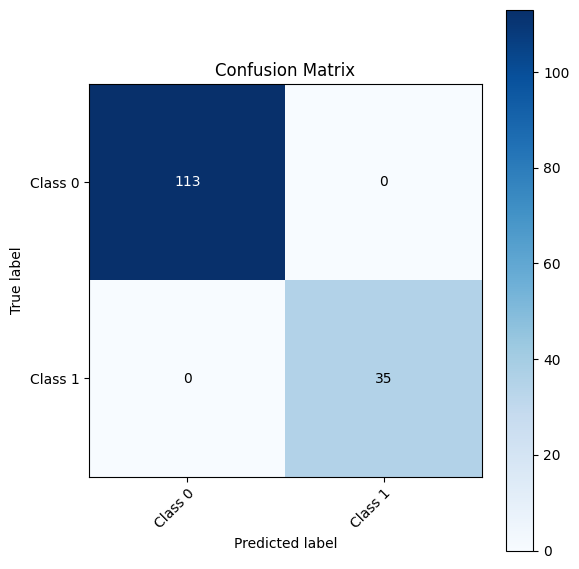

In [38]:
# Confusion matrix
train_eval_result = evaluate_model(
                model=model,
                test_dataloader=train_acc_dataloader
                )

class_names = ['Class 0', 'Class 1']
cm =  train_eval_result['matrix'].astype(int)
add_confusion_matrix2Tensorboard(cm, class_names)
writer = SummaryWriter('./mondi_result/runs/finetuned_model')

        
# Save the plot to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
#plt.close(fig)
buf.seek(0)

# Convert buffer to PIL image
image = Image.open(buf)

# Convert PIL image to PyTorch tensor
image_tensor = ToTensor()(image)

# Log the image tensor to TensorBoard
writer.add_image('Finetuned_Model_Train_Acc', image_tensor)

# Close the writer
writer.close()

plt.show()


## Generate confusion matrix of evalset projection to tensorboard

Validation result: 1.0%


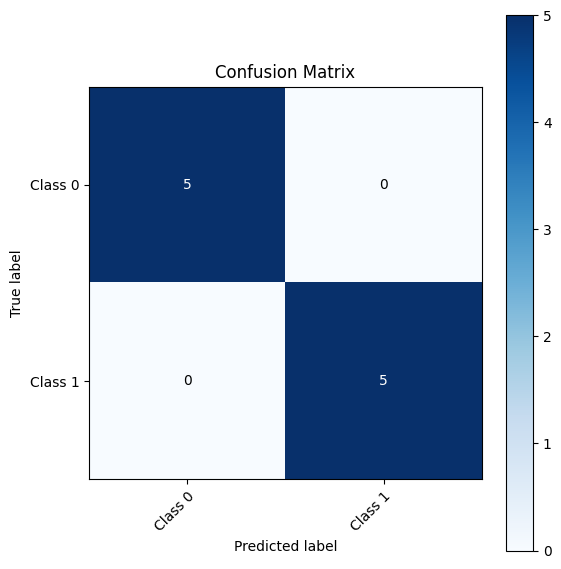

In [39]:
train_eval_result = evaluate_model(
                model=model,
                test_dataloader = eval_acc_dataloader
                )

class_names = ['Class 0', 'Class 1']
cm =  train_eval_result['matrix'].astype(int)
add_confusion_matrix2Tensorboard(cm, class_names)
writer = SummaryWriter('./mondi_result/runs/finetuned_model')

        
# Save the plot to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
#plt.close(fig)
buf.seek(0)

# Convert buffer to PIL image
image = Image.open(buf)

# Convert PIL image to PyTorch tensor
image_tensor = ToTensor()(image)

# Log the image tensor to TensorBoard
writer.add_image('Finetuned_Model_Eval_Acc', image_tensor)

# Close the writer
writer.close()

plt.show()


In [51]:

notebook.list() # View open TensorBoard instances


No known TensorBoard instances running.


In [60]:
notebook.display(port=6006, height=1000)


# Inference

## Load the Best model's checkpoint for test and inference

In [65]:
model_path = './mondi_result/best_model.pt'
model.load_state_dict(torch.load(model_path, map_location={'cuda:0': 'cpu'})['model_state_dict'])

<All keys matched successfully>

In [66]:
eval_acc_dataloader = torch.utils.data.DataLoader(
        dataset= eval_acc_dataset,
        batch_size=1,
        num_workers=5,
        shuffle=False
    )

test_dataloader = torch.utils.data.DataLoader(
        dataset= test_dataset,
        batch_size=1,
        num_workers=5,
        shuffle=False
    )


## Create embedding sapce from evalset

In [67]:
embeddings, classifier,labels, images = extract_embeddings(eval_acc_dataloader, model)

In [68]:
print(embeddings.shape)
print(labels)


(10, 128)
[0 0 0 0 0 1 1 1 1 1]


In [69]:
class_0 = np.mean(embeddings[0:5], axis=0)
class_1 =np.mean(embeddings[5:10], axis=0)
space = [class_0,class_1]

## Create embedding of testset 

In [70]:
embeddings_test, classifier_test,labels_test, images_test = extract_embeddings(test_dataloader, model)

In [71]:
labels_test

array([0, 0, 1, 1])

## Calculate the closest class to the image

In [72]:
l2_distance = PairwiseDistance(2)
for idx in range(4):
    pairwise_distances_c0 = l2_distance.forward(torch.tensor(space[0]),torch.tensor(embeddings_test[idx]))
    pairwise_distances_c1 = l2_distance.forward(torch.tensor(space[1]),torch.tensor(embeddings_test[idx]))
    print("Distances from calss 0 :", pairwise_distances_c0,"  Distances from calss 1:", pairwise_distances_c1)        
    print(f"Ground truth is {'Fichten' if labels_test[idx]==0 else 'Kiefern'} | Predcted image as  {'Fichten' if pairwise_distances_c0 < pairwise_distances_c1 else 'Kiefern'}")
    print()


Distances from calss 0 : tensor(0.4482)   Distances from calss 1: tensor(3.6867)
Ground truth is Fichten | Predcted image as  Fichten

Distances from calss 0 : tensor(0.1862)   Distances from calss 1: tensor(4.0304)
Ground truth is Fichten | Predcted image as  Fichten

Distances from calss 0 : tensor(4.0588)   Distances from calss 1: tensor(0.2054)
Ground truth is Kiefern | Predcted image as  Kiefern

Distances from calss 0 : tensor(4.4944)   Distances from calss 1: tensor(0.4055)
Ground truth is Kiefern | Predcted image as  Kiefern



## Classifier also can be used as auxiliary helper.

In [77]:
clas_pred = torch.argmax(classifier_test).item()
print(f"Classifier result for last image is {'Fichten' if clas_pred==0 else 'Kiefern'}") 

Classifier result for last image is Kiefern
